In [2]:
import pandas as pd
import os
import torch

# Utiliser le dossier courant comme base (par défaut dans les notebooks)
base_dir = os.getcwd()

# Chemins des sous-dossiers pour train et test
file_path = os.path.join(base_dir, r'data\donnees-historiques\prix\hourly_day_ahead_prices_2017_2020.parquet')

data = pd.read_parquet(file_path)

horizons = [6, 12, 24, 48, 72, 168]  # En heures

In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalisation des prix
scaler = MinMaxScaler()
data['price_scaled'] = scaler.fit_transform(data[['price']])

# Conversion en tableau numpy
data_scaled = data['price_scaled'].values


### Normalisation des Prix & creation de sequences de 168h (1 semaine) necessaire pour le LSTM

In [4]:
def create_sequences(data, sequence_length=168):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Créer des séquences
sequence_length = 168
X, y = create_sequences(data_scaled, sequence_length)

# Conversion en tenseurs PyTorch
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Diviser en données d'entraînement et de validation
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]


### CREATION DU MODELE

In [58]:
import torch
import torch.nn as nn

# Vérifiez si CUDA est disponible
if torch.cuda.is_available():
    device = torch.device("cuda")  # Utilisez le GPU
    print("Le GPU est disponible. Utilisation de : ", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Repli sur le CPU
    print("CUDA n'est pas disponible. Utilisation du CPU.")

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel(input_size=1, hidden_size=256, output_size=1, num_layers=3, dropout=0.2).to(device)







Le GPU est disponible. Utilisation de :  NVIDIA GeForce RTX 4060 Laptop GPU


In [59]:
import torch.optim as optim

# Fonction de perte et optimiseur
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [60]:
import torch

X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)


### training LOOP

In [61]:
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suivi des métriques
metrics = {"train_loss": [], "val_loss": [], "val_mae": [], "val_rmse": [], "val_mape": []}

# Paramètres d'entraînement
num_epochs = 50
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Préparer les batches et ajuster les dimensions
        X_batch = X_train[i:i+batch_size].to(device).unsqueeze(-1)  # Assurer (batch_size, seq_len, input_size)
        y_batch = y_train[i:i+batch_size].to(device).unsqueeze(-1)  # Assurer (batch_size, 1)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        epoch_loss += loss.item()

        # Backward pass et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    # Validation
    # Validation
    model.eval()
    with torch.no_grad():
        # Préparer X_val et y_val
        X_val = X_val.squeeze().unsqueeze(-1).to(device)  # Assurer (num_samples, seq_len, input_size)
        y_val = y_val.squeeze().unsqueeze(-1).to(device)  # Assurer (num_samples, 1)

        # Passer dans le modèle
        val_predictions = model(X_val)

        # Calculer la perte de validation
        val_loss = criterion(val_predictions, y_val).item()

        # Calculer les métriques
        val_predictions_cpu = val_predictions.cpu().numpy()
        y_val_cpu = y_val.cpu().numpy()

        # Gérer les zéros pour éviter les divisions par zéro dans MAPE
        epsilon = 1e-8
        y_val_cpu_safe = np.where(y_val_cpu == 0, epsilon, y_val_cpu)
        val_mape = np.mean(np.abs((y_val_cpu - val_predictions_cpu) / y_val_cpu_safe)) * 100

        val_mae = mean_absolute_error(y_val_cpu, val_predictions_cpu)
        val_rmse = np.sqrt(mean_squared_error(y_val_cpu, val_predictions_cpu))

        print(f"Validation - Loss: {val_loss:.4f}, MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}")


Epoch 1/100: 100%|██████████| 873/873 [00:21<00:00, 40.96it/s]


Validation - Loss: 0.0031, MAE: 0.0432, RMSE: 0.0558, MAPE: 429467.62%


Epoch 2/100: 100%|██████████| 873/873 [00:22<00:00, 38.71it/s]


Validation - Loss: 0.0032, MAE: 0.0442, RMSE: 0.0570, MAPE: 425477.84%


Epoch 3/100: 100%|██████████| 873/873 [00:21<00:00, 41.41it/s]


Validation - Loss: 0.0040, MAE: 0.0492, RMSE: 0.0631, MAPE: 408576.28%


Epoch 4/100: 100%|██████████| 873/873 [00:21<00:00, 40.34it/s]


Validation - Loss: 0.0046, MAE: 0.0534, RMSE: 0.0677, MAPE: 397920.91%


Epoch 5/100: 100%|██████████| 873/873 [00:34<00:00, 25.50it/s]


Validation - Loss: 0.0042, MAE: 0.0506, RMSE: 0.0647, MAPE: 404778.88%


Epoch 6/100: 100%|██████████| 873/873 [00:30<00:00, 29.07it/s]


Validation - Loss: 0.0041, MAE: 0.0500, RMSE: 0.0639, MAPE: 406555.31%


Epoch 7/100:  56%|█████▌    | 486/873 [00:16<00:13, 29.41it/s]


KeyboardInterrupt: 

In [47]:
print("Aperçu de X_train :", X_train[:5])
print("Aperçu de y_train :", y_train[:5])
print("Min y_train :", y_train.min().item(), "Max y_train :", y_train.max().item())


Aperçu de X_train : tensor([[0.4010, 0.3992, 0.3805, 0.3666, 0.3613, 0.3583, 0.3583, 0.3590, 0.3575,
         0.3511, 0.3619, 0.3685, 0.3734, 0.3708, 0.3655, 0.3643, 0.3644, 0.3795,
         0.4017, 0.4108, 0.3934, 0.3896, 0.3926, 0.3807, 0.3896, 0.3753, 0.3721,
         0.3622, 0.3598, 0.3657, 0.3807, 0.4017, 0.4193, 0.4195, 0.4298, 0.4223,
         0.4216, 0.4193, 0.4080, 0.4036, 0.4074, 0.4449, 0.4564, 0.4492, 0.4346,
         0.4081, 0.4048, 0.4009, 0.3887, 0.3829, 0.3725, 0.3598, 0.3604, 0.3725,
         0.3975, 0.4358, 0.4463, 0.4501, 0.4481, 0.4441, 0.4424, 0.4393, 0.4358,
         0.4341, 0.4376, 0.4680, 0.6345, 0.4944, 0.4490, 0.4390, 0.4305, 0.4266,
         0.4125, 0.3927, 0.3869, 0.3807, 0.3788, 0.3837, 0.4117, 0.4412, 0.4432,
         0.4432, 0.4428, 0.4418, 0.4394, 0.4390, 0.4313, 0.4257, 0.4291, 0.4407,
         0.4545, 0.4526, 0.4417, 0.4228, 0.4193, 0.4103, 0.3784, 0.3700, 0.3747,
         0.3672, 0.3519, 0.3604, 0.3869, 0.4230, 0.4334, 0.4420, 0.4433, 0.4420,
        

### Predictions sur 168h

In [ ]:
# Dernière séquence pour générer des prédictions
last_sequence = X_val[-1].unsqueeze(0).unsqueeze(-1).to(device)

# Faire des prédictions pour 168 heures
model.eval()
future_predictions = []

with torch.no_grad():
    for _ in range(168):
        prediction = model(last_sequence)
        future_predictions.append(prediction.item())
        last_sequence = torch.cat((last_sequence[:, 1:, :], prediction.unsqueeze(0).unsqueeze(-1)), dim=1)

# Reconvertir à l'échelle d'origine
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


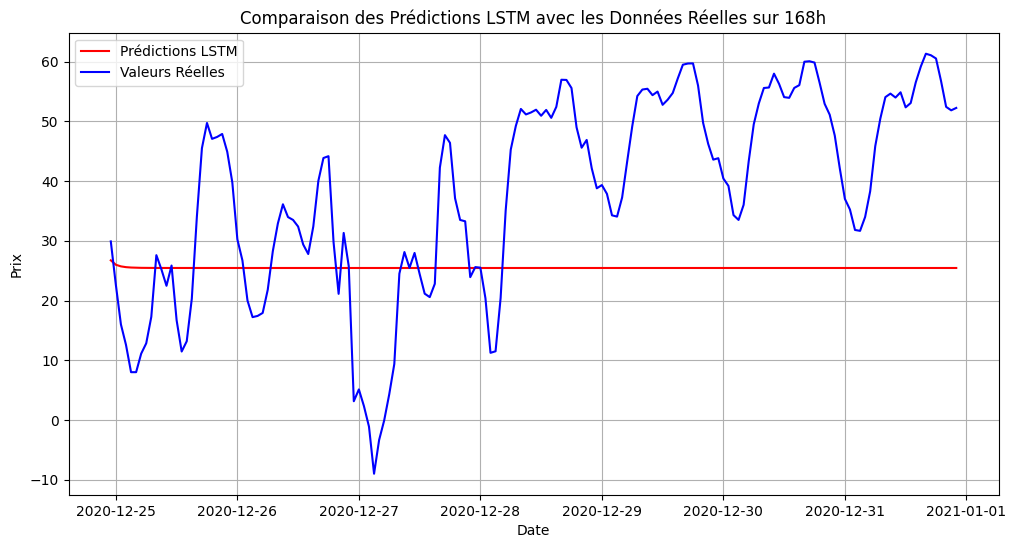

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Tracer les prédictions vs les valeurs réelles
plt.figure(figsize=(12, 6))
plt.plot(prediction_dates, predicted_values, label='Prédictions LSTM', color='red')
plt.plot(prediction_dates, real_values, label='Valeurs Réelles', color='blue')
plt.title('Comparaison des Prédictions LSTM avec les Données Réelles sur 168h')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
print("Exemple de séquence d'entrée pour l'entraînement :")
print(data_scaled[start_index:end_index])


Exemple de séquence d'entrée pour l'entraînement :
[0.36069333 0.34800608 0.34234744 0.33237037 0.33040474 0.33251928
 0.35616642 0.39375168 0.40033356 0.40125681 0.39944009 0.39699795
 0.3925306  0.38574024 0.36962802 0.36962802 0.37186169 0.38657414
 0.39655121 0.39163713 0.38067725 0.34499806 0.34878042 0.33764184
 0.33749293 0.32992822 0.32260178 0.3097954  0.29966942 0.30404741
 0.29526164 0.31554338 0.32328677 0.34050094 0.32939214 0.33365101
 0.35366471 0.33796944 0.33511034 0.34669565 0.36230158 0.37635882
 0.384132   0.38148137 0.38475742 0.34178158 0.37078953 0.3607529
 0.34550436 0.33344254 0.33269798 0.31366709 0.31381601 0.31220776
 0.31998094 0.32263156 0.33859487 0.36039551 0.36295679 0.36432677
 0.36962802 0.36012747 0.35357536 0.35253298 0.35777467 0.37561426
 0.38213658 0.38308961 0.37460166 0.34624892 0.35875748 0.34419394
 0.34285374 0.32945171 0.32602674 0.32388242 0.32602674 0.33892248
 0.35762576 0.37609078 0.38568067 0.38568067 0.38568067 0.384132
 0.39110105 0.

In [28]:
# Stocker les métriques calculées dans un fichier JSON
import json 


metrics_file = "training_metrics_SARIMAX.json"

# Écrire les métriques dans un fichier JSON
with open(metrics_file, "w") as f:
    json.dump(metrics, f, indent=4)

print(f"Les métriques ont été enregistrées dans le fichier : {metrics_file}")

Les métriques ont été enregistrées dans le fichier : training_metrics_SARIMAX.json


: 

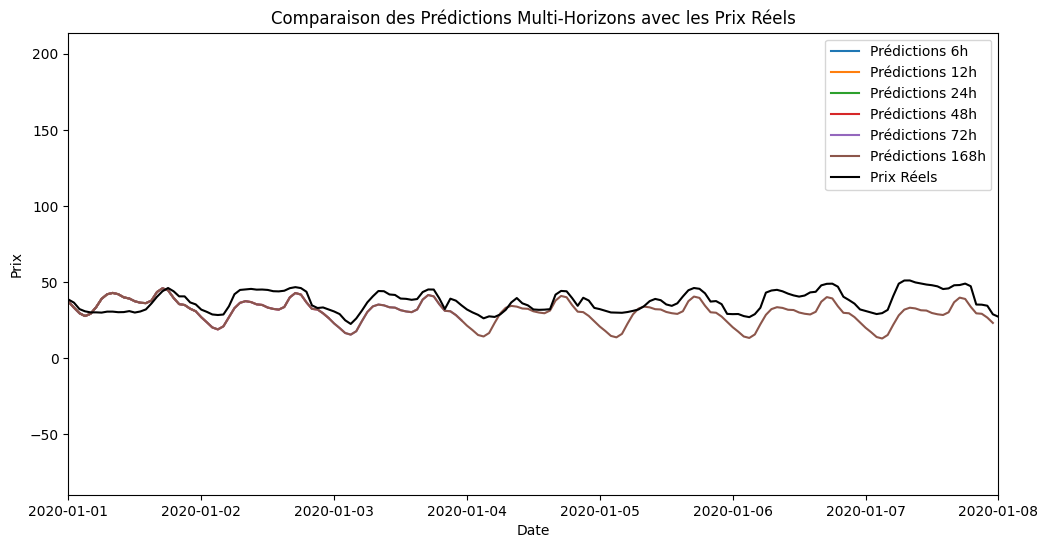

In [24]:
import matplotlib.pyplot as plt

# Visualiser les prédictions vs. les valeurs réelles
plt.figure(figsize=(12, 6))

for horizon in horizons:
    plt.plot(test.index[:len(predictions[horizon])], predictions[horizon], label=f'Prédictions {horizon}h')

# Tracer les données réelles
plt.plot(test.index, test['price'], label='Prix Réels', color='black')

plt.title('Comparaison des Prédictions Multi-Horizons avec les Prix Réels')
plt.xlim('2020-01-01', '2020-01-08')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()
plt.show()
